# 1. Data preparation

In [1]:
%load_ext autoreload
%autoreload 2

from data.datasets import TrainingPicassoDataset
from config.datasets import dataset_configs

z_range = 1000
dataset = 'picasso_test'
train_dataset = TrainingPicassoDataset(dataset_configs[dataset]['training'], z_range)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]



Loaded spots...


  0%|          | 0/93 [00:00<?, ?it/s]

Aligning (94, 41, 31, 31) psfs...


100%|██████████| 93/93 [00:19<00:00,  4.84it/s]


Coords 0.074838787317276 0.9612878561019897
Prepared stacks...
masking
Adding noise... 15
0.001434104171631767 0.03423911017328213
train
Imgs, 	(43152, 31, 31, 1)
		0.001434104171631767, 0.03423911017328213
Coords, 	(43152, 2)
Z coords	(43152,)
val
Imgs, 	(771, 31, 31, 1)
		0.0029602502479591057, 0.026321812771801328
Coords, 	(771, 2)
Z coords	(771,)
test
Imgs, 	(386, 31, 31, 1)
		0.0029602502479591057, 0.031403067063401235
Coords, 	(386, 2)
Z coords	(386,)
0.001434104171631767 0.03423911017328213


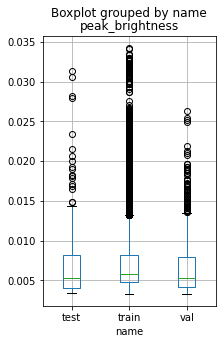

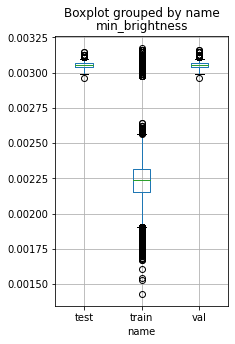

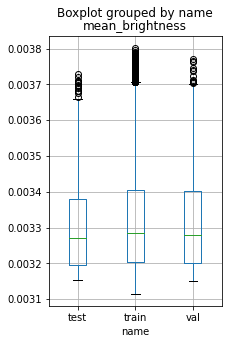

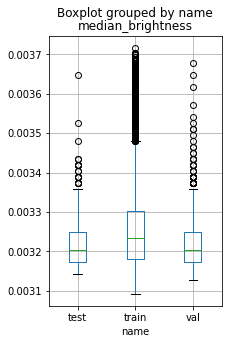

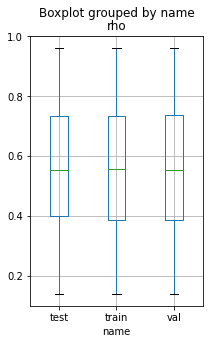

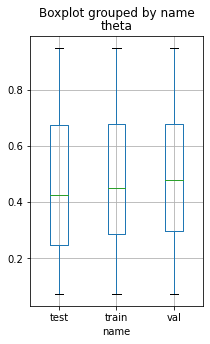

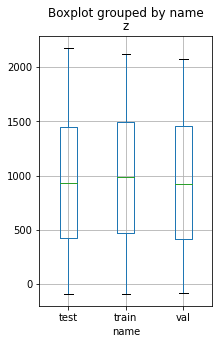

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [3, 5]
def gather_stats(dataset, name, dataset_type='training'):
    records = [] 
    
    if dataset_type == 'training':
        (imgs, coords), z = dataset
    else:
        imgs, coords = dataset
        z = np.zeros((imgs.shape[0]))
    
    for img, coord, z in zip(imgs, coords, z):
        results = {
            'name': name,
            'peak_brightness': img.max(),
            'min_brightness': img.min(),
            'mean_brightness': img.mean(),
            'median_brightness': np.median(img),
            'rho': coord[0],
            'theta': coord[1],
            'z': z,
        }
        records.append(results)
        
    return pd.DataFrame.from_records(records)

if 'all' not in train_dataset.data:
    train = train_dataset.data['train']
    val = train_dataset.data['val']
    test = train_dataset.data['test']

    
    records = []
    records.append(gather_stats(train, 'train'))
    records.append(gather_stats(val, 'val'))
    records.append(gather_stats(test, 'test'))

    
    df = pd.concat(records)
    for col in list(df):
        if col != 'name':
            df.boxplot(by='name', column=col)

(1000,)
Rows 100 Cols 10 n_spaces 1000 n_psfs 1000


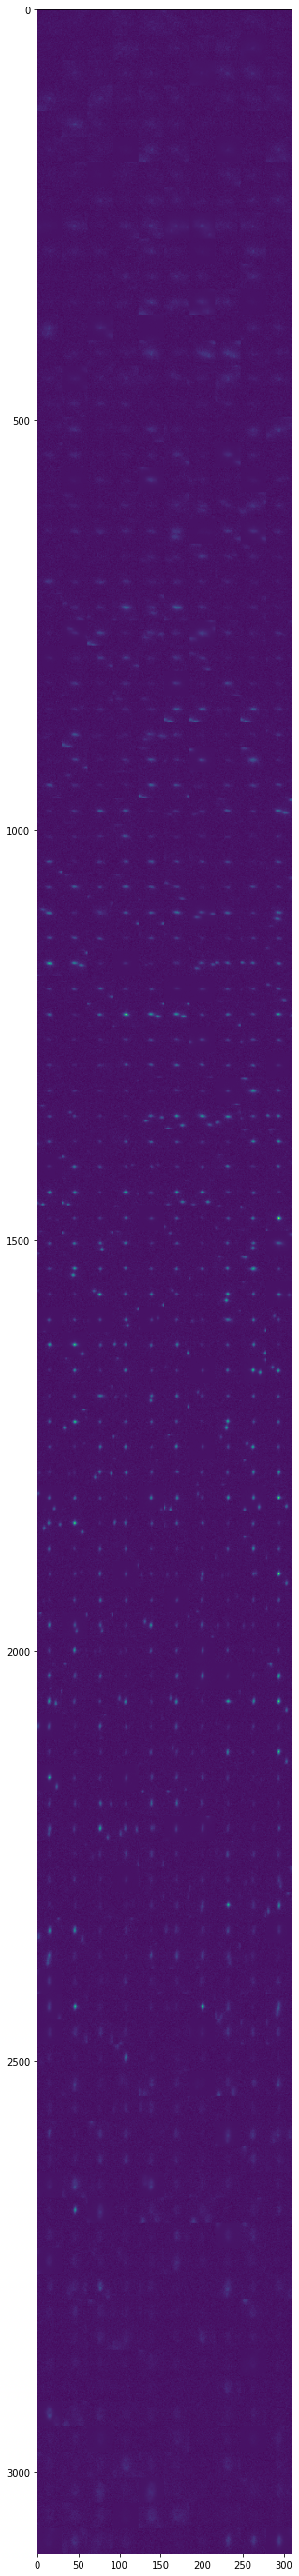

In [3]:
# Inspect training dataset
from data.visualise import grid_psfs
import numpy as np
plt.rcParams['figure.figsize'] = [50, 50]

samples = min(1000, train_dataset.data['train'][1].shape[0])
sub_idx = np.random.choice(np.arange(0, train_dataset.data['train'][1].shape[0]), samples, replace=False)
print(sub_idx.shape)
sub_zs = train_dataset.data['train'][1][sub_idx]
sub_imgs = train_dataset.data['train'][0][0][sub_idx]
idx = np.argsort(sub_zs)
sub_imgs = sub_imgs[idx]

plt.imshow(grid_psfs(sub_imgs.squeeze()))
plt.show()





# 2. Training the model

Currently, I'm using 2 'calibration' datasets to see if my model can adapt from one to the other.
All of the training dataset is used for training, and the 2nd dataset is used as validation.

In [4]:
TRAIN_NEW_MODEL = True

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Loading model...
Loading functional resnet with bound 31



Epoch 195: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 643: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 759: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 880: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 979: ReduceLROnPlateau reducing learning rate to 1e-07.



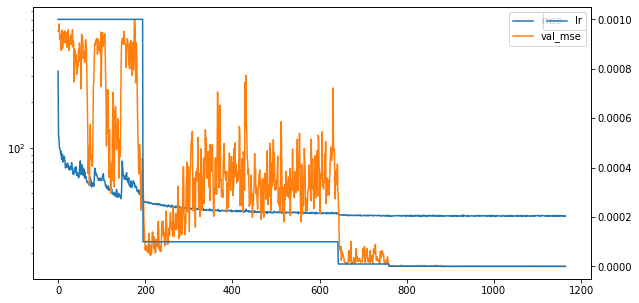

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 31, 31, 1)]  0           []                               
                                                                                                  
 sequential_2 (Sequential)      (None, 512)          21303936    ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 tf.concat_1 (TFOpLambda)       (None, 514)          0           ['sequential_2[0][0]',           
                                                                  'input_4[0][0]']          

In [6]:
%load_ext autoreload
%autoreload 2

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from model.model import load_new_model, save_model, load_trained_model

from wandb.keras import WandbCallback
import numpy as np
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback

import wandb
import os
import logging

wandb.login()

bound = train_dataset.data['train'][0][0].shape[1]

BATCH_SIZE = 2**10
LEARNING_RATE = 1e-3
wandb.init(project="smlm_z",
           name=dataset,
           config={
               "batch_size": BATCH_SIZE,
               "learning_rate": LEARNING_RATE,
               "dataset": dataset,
               "bound": bound,
           })

save_path = os.path.join(os.getcwd(), 'wandb')
import glob
wandb.save(f'{save_path}/*.py', base_path=save_path)

def train_model(dataset, val_dataset=None, pretrained_model=None):
    if not val_dataset:
        val_dataset = dataset['val']
#     for k in dataset:
#         imgs = dataset[k][0][0]
#         norm_imgs = imgs / imgs.max(axis=(1, 2))[:, np.newaxis, np.newaxis]
#         dataset[k][0][0] = norm_imgs

    model = pretrained_model or load_new_model(bound, LEARNING_RATE)

    callbacks = [
        ReduceLROnPlateau(
        monitor='loss', factor=0.1, patience=50, verbose=True,
        mode='min', min_delta=1, cooldown=50, min_lr=1e-7,),
#         ReduceLROnPlateau(
#         monitor='val_mean_absolute_error', factor=0.1, patience=50, verbose=True,
#         mode='min', min_delta=1, cooldown=50, min_lr=1e-10,),
        EarlyStopping(monitor='val_mean_absolute_error', patience=500, verbose=False, min_delta=1, restore_best_weights=True),
#         WandbCallback(save_model=False),
        TqdmCallback(verbose=1),
    ]

    history = model.fit(*dataset['train'], epochs=5000, verbose=False, batch_size=BATCH_SIZE, validation_data=(*val_dataset,), callbacks=callbacks)
    
    plt.rcParams['figure.figsize'] = [10, 5]
    fig, ax1 = plt.subplots()
    ax1.plot(history.history['mean_absolute_error'], label='mse')
    ax1.plot(history.history['val_mean_absolute_error'], label='val_mse')
    ax1.set_yscale('log')
    ax1.legend(loc=1)
    ax2 = ax1.twinx()
    ax2.plot(history.history['lr'], label='lr')
    ax2.legend(loc=0)

    plt.show()
    return model

if TRAIN_NEW_MODEL == True:
    model = train_model(train_dataset.data)
    save_model(model, dataset)
else:
    model = load_model(load_regression_model(LEARNING_RATE))

tmp_x = train_dataset.data['train'][0][0][0:2], train_dataset.data['train'][0][1][0:2]
model(tmp_x)
print(model.summary())

In [1]:
import seaborn as sns
import random

test_x, test_y = train_dataset.data['test']

# from scipy.ndimage import median_filter
# test_x[0] = np.stack([median_filter(d, size=2) for d in test_x[0].copy()])

# from final_project.smlm_3d.data.datasets import mask_img_stack
# test_x[0] = mask_img_stack(test_x[0].copy(), radius=12)


pred_y = model.predict(test_x).squeeze()
error = abs(test_y-pred_y)

print(f'Mean error {np.mean(error)}')
print(f'std error {np.std(error)}')

sns.histplot(error)
plt.xlabel('Error (nm)')
plt.show()


# 20220425_Miguel/training_20nm
# Cubic spline model
# Mean error 34.24343542454768
# std error 36.64187932722746

# Spline super-sampling model w/o plane fit
# Mean error 28.941918452166664
# std error 26.241176376179656


# Spline fit super-sampling model w/ improved image normalisation
# Mean error 28.089797139687477
# std error 24.976300570311047

# Latest results - spline fit super-sampling w/ improved image normalisation + plane-fit
# Mean error 27.546041584423875
# std error 26.033701351832462



# latest
# Mean error 72.83350251990716
# std error 130.39968131300466


idx = np.argsort(error)[::-1][0:1000]
test_imgs = test_x[0].squeeze()[idx]
plt.rcParams['figure.figsize'] = [30, 50]
plt.imshow(grid_psfs(test_imgs))
plt.show()

def snr(img):
    return img.max() / np.median(img)
plt.rcParams['figure.figsize'] = [3, 5]
plt.scatter(test_y, pred_y)
plt.show()
error = abs(pred_y-test_y)
plt.boxplot(error)
plt.show()

plt.scatter([snr(img) for img in test_imgs], error, marker='.', alpha=0.2)
plt.xlabel('snr')
plt.ylabel('error [nm]')
plt.show()

NameError: name 'train_dataset' is not defined